## Preamble

In [1]:
import os
import numpy as np
#from scipy import signal
import matplotlib.pyplot as plt

nz=201; nx=201; h=10

fpeak=7; dt=0.002; nt=2000

ntr=100

def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def read_su(filename,n=(ntr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

# def read_snap(filename,n=(nsnap,nxsnap,nzsnap),i=26):
#     tmp=np.fromfile(filename,dtype='float32').reshape(n).T
#     return tmp[:,:,i]

def imshow(data,perc=None,clip=None,clipmin=None,extent=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],extent=extent,cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def run(app='../../exe/GradientTest',setup='setup',np=1,nthreads=4,out=None):
    '''
    run(app,setup,np=1,nthreads=8)
    run in a bash env
    ----------------------------
    app      : application/executable to run
    setup    : setup file
    np       : number of MPI processors (default=1)
    nthreads : number of OpenMP threads (default=8)
    
    Caveat: np*nthreads should not exceed total number of CPU cores
    otherwise the running will be very slow
    '''
    
    !echo 'ulimit -s unlimited' > run.sh
    str=f"export OMP_NUM_THREADS={nthreads}"
    !echo $str >> run.sh
    str=f"{app} {setup}"
    !echo $str >> run.sh
    !chmod +x run.sh
    if out==None:
        !./run.sh
    else:
        !./run.sh > {out}

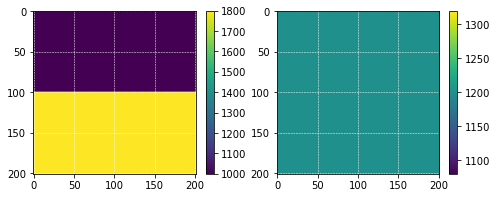

In [2]:
# True
!makevel nz=100 nx=$nx v000=1000 > c1
!makevel nz=101 nx=$nx v000=1800 > c2
!cat c1 c2 > tmp && transp < tmp n1=$nx > true
!rm c1 c2 tmp

!makevel nz=1   nx=$nx v000=100  > topo

# Background
!makevel nz=$nz nx=$nx v000=1200 > init

#plot
plt.figure(figsize=(8,3))
true=read('true'); init=read('init')
plt.subplot(1,2,1); imshow(true)
plt.subplot(1,2,2); imshow(init)

In [3]:
!cat setup_default

MODEL_SIZE              '201 201 1'
MODEL_SPACING           '10 10 1'
FILE_MODEL              true
MODEL_ATTRIBUTES        vp #'vp rho'
FILE_TOPO               'topo'

IS_FREESURFACE          F

ACQUI_GEOMETRY          spread
FS                      '40 500 500'
FR                      '40 10  0'
DR                      '0  20 0'
NR                      100

SCOMP                   vz
RCOMP                   vz #'p vz'

WAVELET_TYPE            ricker
#T0                      0.5
#FILE_WAVELET            'fricker_dt6000.su'

IF_HICKS        F
IF_BLOOM        F

IF_USE_RANDOM   F

NT           2000
DT           0.002
FPEAK        7

## for PFEI ##
FILE_DATA_PREFIX    'results_obs/Ru_Shot'
WEIGHTING           'none'

PARAMETER           'vp:1000:1800'

SMOOTHING     'none'
#PRECO         'z^0'


#DESCENT_DIR     'random'  #'-curr%pg'

#LS_SCALING  'none'


#SNAPSHOT     p
#NSNAPSHOT    50

IF_USE_CHECKPOINT   F


In [4]:
vp=init
vs=vp/np.sqrt(3)
rho=1000.
def gvp(glda):     return  glda            *2*rho*vp
def gvs(glda,gmu): return (glda*(-2) + gmu)*2*rho*vs

## Velocity-Stress

### vz-vz

#### Obs & Syn data

In [5]:
!cp setup_default setup
!echo "DIR_OUT     results_obs" >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 630664 Nov 20 15:14 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: 65073d2
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 16:28:59
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_obs
 Output directory:results_obs/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/dx

In [6]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "DIR_OUT     results_syn" >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 630664 Nov 20 15:14 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: 65073d2
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 16:29:02
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_syn
 Output directory:results_syn/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/dx

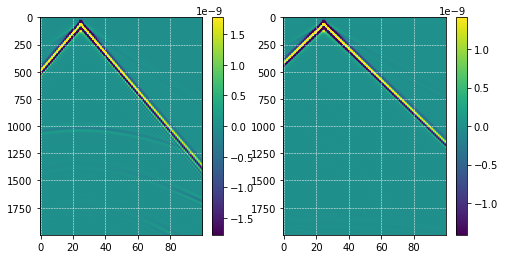

In [7]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); imshow(read_su('results_obs/Ru_Shot0001.su'),perc=98)
plt.subplot(1,2,2); imshow(read_su('results_syn/Ru_Shot0001.su'),perc=98)

#### Gradient

In [8]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "ALPHAS      1 " >> setup
run(app='../../exe/gradienttest_PSV_FDSG_O4_velocities-density')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 43 Nov 20 16:05 ../../exe/GradientTest -> gradienttest_PSV_FDSG_O4_velocities-density
 Git Commit: 65073d2
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 16:29:33
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI       
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT is NOT found, take default: ./results/
 Output directory:./results/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ

 it----         500
 fld_a minmax values:  -5.26389578E-16   4.02480093E-16
 fld_u minmax values:  -2.44740228E-09   2.71616063E-09
 Elapsed time to load boundary               2.84855366E-02
 Elapsed time to update stresses            0.491369724    
 Elapsed time to rm source stresses          6.67548180E-03
 Elapsed time to update velocities          0.490752459    
 Elapsed time to rm source velocities        3.74460220E-03
 Elapsed time ----------------------------
 Elapsed time to add adjsource stresses      4.29701805E-03
 Elapsed time to update adj stresses        0.476176977    
 Elapsed time to add adjsource velocities    1.17709637E-02
 Elapsed time to update adj velocities      0.391421318    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   7.76934624E-03
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


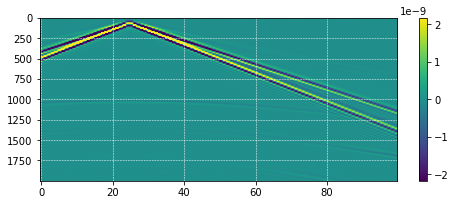

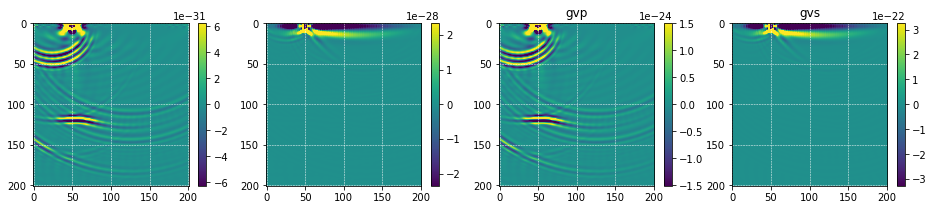

In [9]:
plt.figure(figsize=(8,3))
imshow(read_su('results/dadj_Shot0001.su'),perc=98)

# plt.figure(figsize=(8,3))
# plt.subplot(1,2,1); imshow(read('results/a_star_u%glda'),title='glda',perc=98)
# plt.subplot(1,2,2); imshow(read('results/a_star_u%gmu' ),title='gmu' ,perc=98)

corr=read('results/correlate_gradient',n=(3*nx,nz))
glda=corr[:,  nx:2*nx]
gmu =corr[:,2*nx:]

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(glda,perc=98)
plt.subplot(1,4,2); imshow(gmu ,perc=98)
plt.subplot(1,4,3); imshow(gvp(glda),title='gvp',perc=98)
plt.subplot(1,4,4); imshow(gvs(glda,gmu),title='gvs',perc=98)

#### gradienttest_PSV_FDSG_O4_velocities-density on gvp

In [10]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
#!echo "PARAMETER   'vp:1500:2000'" >> setup
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup

!rm -r results
!../../exe/gradienttest_PSV_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06   1042.54858       1042.54846       12.2070312     -0.330939025      -2.71105245E-02 F
 1st cond   9.99999975E-05   1042.54834       1042.54846      -1.22070312     -0.330939025      0.271105260     T
 1st cond   1.00000005E-03   1042.54822       1042.54846     -0.244140610     -0.330939025       1.35552633     T
 1st cond   9.99999978E-03   1042.54553       1042.54846     -0.292968750     -0.330939025       1.12960517     T
 1st cond  0.100000001       1042.51477       1042.54846     -0.336914062     -0.330939025      0.982265413     T
 1st cond   1.00000000       1042.23022       1042.54846     -0.318237305     -0.330939025       1.03991270     T


In [11]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
#!echo "PARAMETER   'vp:1500:2000'" >> setup
!echo "ALPHAS '-1e-5 -1e-4 -1e-3 -1e-2 -1e-1 -1' " >> setup

!rm -r results
!../../exe/gradienttest_PSV_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond  -9.99999975E-06   1042.54846       1042.54846      -0.00000000     -0.330939025             Infinity T
 1st cond  -9.99999975E-05   1042.54846       1042.54846      -0.00000000     -0.330939025             Infinity T
 1st cond  -1.00000005E-03   1042.54858       1042.54846     -0.122070305     -0.330939025       2.71105266     F
 1st cond  -9.99999978E-03   1042.55164       1042.54846     -0.317382812     -0.330939025       1.04271245     F
 1st cond -0.100000001       1042.57690       1042.54846     -0.284423828     -0.330939025       1.16354179     F
 1st cond  -1.00000000       1042.87866       1042.54846     -0.330200195     -0.330939025       1.00223756     F


#### gradienttest_PSV_FDSG_O4_velocities-density on gvs

In [12]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "PARAMETER    'vs:578:1039'" >> setup
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup

!rm -r results
!../../exe/gradienttest_PSV_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06   71.3662491       71.3663330      -8.39233398      -5.38862038      0.642088413     T
 1st cond   9.99999975E-05   71.3656998       71.3663330      -6.33239746      -5.38862038      0.850960553     T
 1st cond   1.00000005E-03   71.3598480       71.3663330      -6.48498487      -5.38862038      0.830937982     T
 1st cond   9.99999978E-03   71.3039474       71.3663330      -6.23855591      -5.38862038      0.863760829     T
 1st cond  0.100000001       70.7562332       71.3663330      -6.10099792      -5.38862038      0.883235872     T
 1st cond   1.00000000       66.9689026       71.3663330      -4.39743042      -5.38862038       1.22540212     T


In [13]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "PARAMETER    'vs:578:1039'" >> setup
!echo "ALPHAS '-1e-5 -1e-4 -1e-3 -1e-2 -1e-1 -1' " >> setup

!rm -r results
!../../exe/gradienttest_PSV_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond  -9.99999975E-06   71.3663559       71.3663330      -2.28881836      -5.38862038       2.35432410     F
 1st cond  -9.99999975E-05   71.3669205       71.3663330      -5.87463379      -5.38862038      0.917269170     F
 1st cond  -1.00000005E-03   71.3723984       71.3663330      -6.06536818      -5.38862038      0.888424277     F
 1st cond  -9.99999978E-03   71.4283142       71.3663330      -6.19812012      -5.38862038      0.869395912     F
 1st cond -0.100000001       71.9962540       71.3663330      -6.29920959      -5.38862038      0.855443895     F
 1st cond  -1.00000000       77.1340637       71.3663330      -5.76773071      -5.38862038      0.934270442     F


### vz-vx

#### Obs & Syn data

In [14]:
!cp setup_default setup
!echo "SCOMP       vz" >> setup
!echo "RCOMP       vx" >> setup
!echo "DIR_OUT     results_obs" >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 630664 Nov 20 15:14 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: 65073d2
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 16:31:37
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_obs
 Output directory:results_obs/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/dx

In [15]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       vz" >> setup
!echo "RCOMP       vx" >> setup
!echo "DIR_OUT     results_syn" >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 630664 Nov 20 15:14 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: 65073d2
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 16:31:39
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_syn
 Output directory:results_syn/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/dx

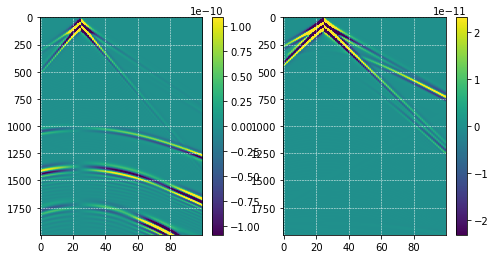

In [16]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); imshow(read_su('results_obs/Ru_Shot0001.su'),perc=98)
plt.subplot(1,2,2); imshow(read_su('results_syn/Ru_Shot0001.su'),perc=98)

#### Gradient

In [17]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       vz" >> setup
!echo "RCOMP       vx" >> setup
!echo "ALPHAS      1 " >> setup
run(app='../../exe/gradienttest_PSV_FDSG_O4_velocities-density')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
lrwxrwxrwx 1 wzhou wzhou 43 Nov 20 16:05 ../../exe/GradientTest -> gradienttest_PSV_FDSG_O4_velocities-density
 Git Commit: 65073d2
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 16:31:48
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI       
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT is NOT found, take default: ./results/
 Output directory:./results/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ

 it----         500
 fld_a minmax values:  -4.16835915E-18   4.38408909E-18
 fld_u minmax values:  -2.44740228E-09   2.71616063E-09
 Elapsed time to load boundary               1.96070671E-02
 Elapsed time to update stresses            0.489306450    
 Elapsed time to rm source stresses          6.92844391E-04
 Elapsed time to update velocities          0.400392532    
 Elapsed time to rm source velocities        6.88552856E-04
 Elapsed time ----------------------------
 Elapsed time to add adjsource stresses      9.45353508E-03
 Elapsed time to update adj stresses        0.492679596    
 Elapsed time to add adjsource velocities    7.98106194E-03
 Elapsed time to update adj velocities      0.450386763    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   2.66001225E-02
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


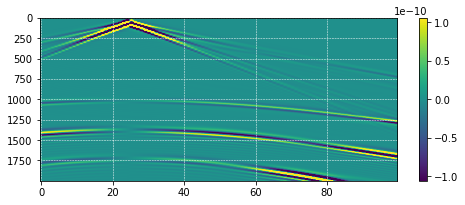

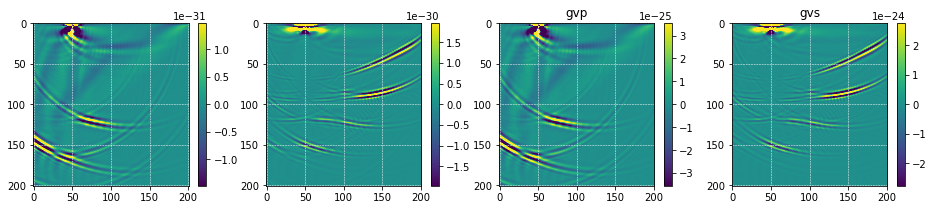

In [18]:
plt.figure(figsize=(8,3))
imshow(read_su('results/dadj_Shot0001.su'),perc=98)

corr=read('results/correlate_gradient',n=(3*nx,nz))
glda=corr[:,  nx:2*nx]
gmu =corr[:,2*nx:]

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(glda,perc=98)
plt.subplot(1,4,2); imshow(gmu ,perc=98)
plt.subplot(1,4,3); imshow(gvp(glda),title='gvp',perc=98)
plt.subplot(1,4,4); imshow(gvs(glda,gmu),title='gvs',perc=98)

#### gradienttest_PSV_FDSG_O4_velocities-density on gvp

In [19]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       vz" >> setup
!echo "RCOMP       vx" >> setup
#!echo "PARAMETER   'vp:1500:2000'" >> setup
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup

!rm -r results
!../../exe/gradienttest_PSV_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06   16.4475327       16.4475422     -0.953674316     -0.485732079      0.509326994     T
 1st cond   9.99999975E-05   16.4474888       16.4475422     -0.534057617     -0.485732079      0.909512520     T
 1st cond   1.00000005E-03   16.4471321       16.4475422     -0.410079926     -0.485732079       1.18448150     T
 1st cond   9.99999978E-03   16.4428616       16.4475422     -0.468063354     -0.485732079       1.03774858     T
 1st cond  0.100000001       16.4012318       16.4475422     -0.463104248     -0.485732079       1.04886115     T
 1st cond   1.00000000       16.0232410       16.4475422     -0.424301147     -0.485732079       1.14478147     T


In [20]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       vz" >> setup
!echo "RCOMP       vx" >> setup
#!echo "PARAMETER   'vp:1500:2000'" >> setup
!echo "ALPHAS '-1e-5 -1e-4 -1e-3 -1e-2 -1e-1 -1' " >> setup

!rm -r results
!../../exe/gradienttest_PSV_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond  -9.99999975E-06   16.4475403       16.4475422      0.190734863     -0.485732079      -2.54663491     T
 1st cond  -9.99999975E-05   16.4475899       16.4475422     -0.476837158     -0.485732079       1.01865399     F
 1st cond  -1.00000005E-03   16.4480171       16.4475422     -0.474929780     -0.485732079       1.02274501     F
 1st cond  -9.99999978E-03   16.4520760       16.4475422     -0.453376770     -0.485732079       1.07136512     F
 1st cond -0.100000001       16.4935360       16.4475422     -0.459938049     -0.485732079       1.05608153     F
 1st cond  -1.00000000       16.9424934       16.4475422     -0.494951248     -0.485732079      0.981373608     F


#### gradienttest_PSV_FDSG_O4_velocities-density on gvs

In [21]:
!cp setup_default setup
!echo 'FILE_MODEL   init' >> setup
!echo "SCOMP        vz" >> setup
!echo "RCOMP        vx" >> setup
!echo "PARAMETER   'vs:578:1039'" >> setup
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup

!rm -r results
!../../exe/gradienttest_PSV_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06   8.18423367       8.18424988      -1.62124634      -1.33596861      0.824038029     T
 1st cond   9.99999975E-05   8.18412209       8.18424988      -1.27792358      -1.33596861       1.04542136     T
 1st cond   1.00000005E-03   8.18292904       8.18424988      -1.32083881      -1.33596861       1.01145470     T
 1st cond   9.99999978E-03   8.17117214       8.18424988      -1.30777359      -1.33596861       1.02155960     T
 1st cond  0.100000001       8.05730343       8.18424988      -1.26946449      -1.33596861       1.05238760     T
 1st cond   1.00000000       7.30140877       8.18424988     -0.882841110      -1.33596861       1.51326048     T


In [22]:
!cp setup_default setup
!echo 'FILE_MODEL   init' >> setup
!echo "SCOMP        vz" >> setup
!echo "RCOMP        vx" >> setup
!echo "PARAMETER   'vs:578:1039'" >> setup
!echo "ALPHAS '-1e-5 -1e-4 -1e-3 -1e-2 -1e-1 -1' " >> setup

!rm -r results
!../../exe/gradienttest_PSV_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond  -9.99999975E-06   8.18426991       8.18424988      -2.00271606      -1.33596861      0.667078376     F
 1st cond  -9.99999975E-05   8.18439388       8.18424988      -1.44004822      -1.33596861      0.927724898     F
 1st cond  -1.00000005E-03   8.18554211       8.18424988      -1.29222858      -1.33596861       1.03384852     F
 1st cond  -9.99999978E-03   8.19740772       8.18424988      -1.31578445      -1.33596861       1.01533997     F
 1st cond -0.100000001       8.31975937       8.18424988      -1.35509491      -1.33596861      0.985885620     F
 1st cond  -1.00000000       9.90973282       8.18424988      -1.72548294      -1.33596861      0.774257779     F


## Momenta-Strains

### pz-pz

#### Obs & Syn data

In [46]:
!cp setup_default setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       pz" >> setup
!echo "DIR_OUT     results_obs" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 642672 Nov 20 16:35 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: 65073d2
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 17:01:21
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_obs
 Output directory:results_obs/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/dx

In [47]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       pz" >> setup
!echo "DIR_OUT     results_syn" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 642672 Nov 20 16:35 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: 65073d2
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 17:01:24
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_syn
 Output directory:results_syn/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/dx

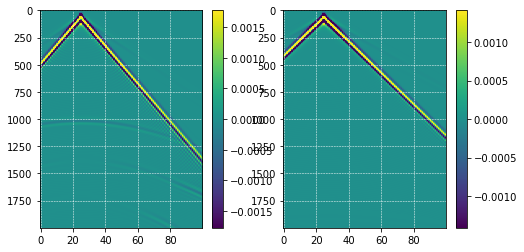

In [48]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); imshow(read_su('results_obs/Ru_Shot0001.su'),perc=98)
plt.subplot(1,2,2); imshow(read_su('results_syn/Ru_Shot0001.su'),perc=98)

#### Gradient

In [49]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       pz" >> setup
!echo "ALPHAS      1 " >> setup
run(app='../../exe/gradienttest_DAS_FDSG_O4_velocities-density')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 919552 Nov 20 16:50 ../../exe/gradienttest_DAS_FDSG_O4_velocities-density
 Git Commit: 320b080
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 17:01:27
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI       
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT is NOT found, take default: ./results/
 Output directory:./results/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax

 it----         500
 fld_a minmax values:  -5.26389515E-04   4.02480015E-04
 fld_u minmax values:  -2.44740210E-03   2.71616108E-03
 Elapsed time to load boundary               2.34761238E-02
 Elapsed time to update strains             0.540865421    
 Elapsed time to rm source strains           6.70385361E-03
 Elapsed time to update momenta             0.753345966    
 Elapsed time to rm source momenta           8.07762146E-04
 Elapsed time ----------------------------
 Elapsed time to add adjsource strains       8.56018066E-03
 Elapsed time to update adj strains         0.612424374    
 Elapsed time to add adjsource momenta       1.01890564E-02
 Elapsed time to update adj momenta         0.689812660    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   2.45528221E-02
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


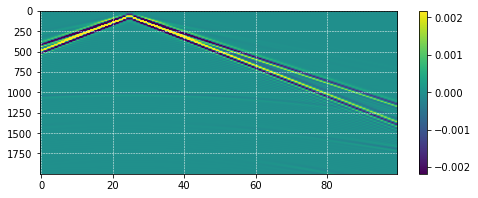

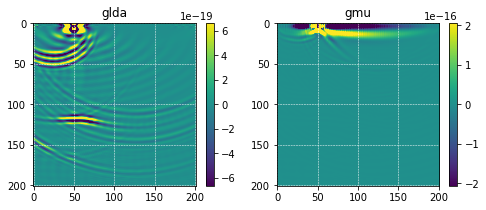

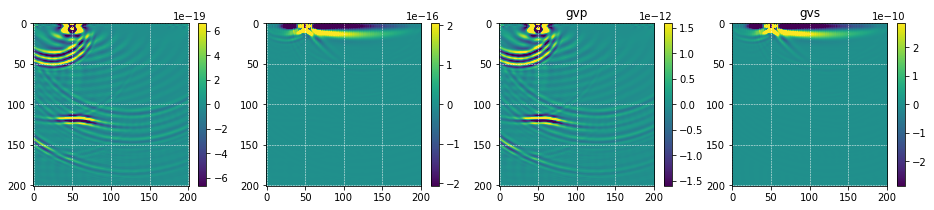

In [50]:
plt.figure(figsize=(8,3))
imshow(read_su('results/dadj_Shot0001.su'),perc=98)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); imshow(read('results/a_star_u%glda'),title='glda',perc=98)
plt.subplot(1,2,2); imshow(read('results/a_star_u%gmu' ),title='gmu' ,perc=98)

corr=read('results/correlate_gradient',n=(3*nx,nz))
glda=corr[:,  nx:2*nx]
gmu =corr[:,2*nx:]

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(glda,perc=98)
plt.subplot(1,4,2); imshow(gmu ,perc=98)
plt.subplot(1,4,3); imshow(gvp(glda),title='gvp',perc=98)
plt.subplot(1,4,4); imshow(gvs(glda,gmu),title='gvs',perc=98)

#### GradientTest on gvp

In [51]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       pz" >> setup
#!echo "PARAMETER   'vp:1500:2000'" >> setup
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup

!rm -r results
!../../exe/gradienttest_DAS_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06   918.368347       918.368164       18.3105469     -0.280541599      -1.53213115E-02 F
 1st cond   9.99999975E-05   918.368164       918.368164       0.00000000     -0.280541599            -Infinity T
 1st cond   1.00000005E-03   918.367859       918.368164     -0.305175781     -0.280541599      0.919278681     T
 1st cond   9.99999978E-03   918.366455       918.368164     -0.170898438     -0.280541599       1.64156914     T
 1st cond  0.100000001       918.343689       918.368164     -0.244750977     -0.280541599       1.14623284     T
 1st cond   1.00000000       918.117371       918.368164     -0.250793457     -0.280541599       1.11861610     T


In [52]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       pz" >> setup_default
#!echo "PARAMETER   'vp:1500:2000'" >> setup
!echo "ALPHAS '-1e-5 -1e-4 -1e-3 -1e-2 -1e-1 -1' " >> setup

!rm -r results
!../../exe/gradienttest_DAS_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond  -9.99999975E-06   918.368164       918.368164      -0.00000000     -0.280541599             Infinity T
 1st cond  -9.99999975E-05   918.368164       918.368164      -0.00000000     -0.280541599             Infinity T
 1st cond  -1.00000005E-03   918.368530       918.368164     -0.366210908     -0.280541599      0.766065657     F
 1st cond  -9.99999978E-03   918.371765       918.368164     -0.360107422     -0.280541599      0.779049754     F
 1st cond -0.100000001       918.396545       918.368164     -0.283813477     -0.280541599      0.988471746     F
 1st cond  -1.00000000       918.638062       918.368164     -0.269897461     -0.280541599       1.03943765     F


#### GradientTest on gvs

In [53]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       pz" >> setup
!echo "PARAMETER    'vs:578:1039'" >> setup
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup

!rm -r results
!../../exe/gradienttest_DAS_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06   68.6572037       68.6572495      -4.57763672      -5.37550735       1.17429745     T
 1st cond   9.99999975E-05   68.6566620       68.6572495      -5.87463379      -5.37550735      0.915037036     T
 1st cond   1.00000005E-03   68.6512146       68.6572495      -6.03485060      -5.37550735      0.890744090     T
 1st cond   9.99999978E-03   68.5973358       68.6572495      -5.99136353      -5.37550735      0.897209346     T
 1st cond  0.100000001       68.0634842       68.6572495      -5.93765259      -5.37550735      0.905325353     T
 1st cond   1.00000000       64.3284454       68.6572495      -4.32880402      -5.37550735       1.24179971     T


In [54]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       pz" >> setup
!echo "PARAMETER    'vs:578:1039'" >> setup
!echo "ALPHAS '-1e-5 -1e-4 -1e-3 -1e-2 -1e-1 -1' " >> setup

!rm -r results
!../../exe/gradienttest_DAS_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond  -9.99999975E-06   68.6573181       68.6572495      -6.86645508      -5.37550735      0.782864988     F
 1st cond  -9.99999975E-05   68.6579285       68.6572495      -6.79016113      -5.37550735      0.791661263     F
 1st cond  -1.00000005E-03   68.6636658       68.6572495      -6.41632032      -5.37550735      0.837786615     F
 1st cond  -9.99999978E-03   68.7176895       68.6572495      -6.04400635      -5.37550735      0.889394701     F
 1st cond -0.100000001       69.2662659       68.6572495      -6.09016418      -5.37550735      0.882653952     F
 1st cond  -1.00000000       73.9782333       68.6572495      -5.32098389      -5.37550735       1.01024687     F


### pz-px

#### Obs & Syn data

In [55]:
!cp setup_default setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       px" >> setup
!echo "DIR_OUT     results_obs" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 642672 Nov 20 16:35 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: 65073d2
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 17:03:49
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_obs
 Output directory:results_obs/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/dx

In [56]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       px" >> setup
!echo "DIR_OUT     results_syn" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 642672 Nov 20 16:35 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: 65073d2
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 17:03:52
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_syn
 Output directory:results_syn/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/dx

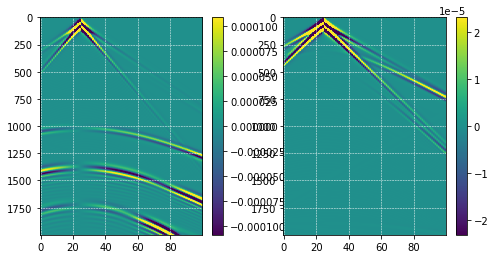

In [57]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); imshow(read_su('results_obs/Ru_Shot0001.su'),perc=98)
plt.subplot(1,2,2); imshow(read_su('results_syn/Ru_Shot0001.su'),perc=98)

#### Gradient

In [58]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       px" >> setup
!echo "ALPHAS      1 " >> setup
run(app='../../exe/gradienttest_DAS_FDSG_O4_velocities-density')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 919552 Nov 20 16:50 ../../exe/gradienttest_DAS_FDSG_O4_velocities-density
 Git Commit: 320b080
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 17:03:55
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI       
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT is NOT found, take default: ./results/
 Output directory:./results/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax

 it----         500
 fld_a minmax values:  -4.16835837E-06   4.38408642E-06
 fld_u minmax values:  -2.44740210E-03   2.71616108E-03
 Elapsed time to load boundary               2.57782936E-02
 Elapsed time to update strains             0.503020763    
 Elapsed time to rm source strains           7.10725784E-04
 Elapsed time to update momenta             0.699099541    
 Elapsed time to rm source momenta           7.26222992E-04
 Elapsed time ----------------------------
 Elapsed time to add adjsource strains       2.00791359E-02
 Elapsed time to update adj strains         0.469384193    
 Elapsed time to add adjsource momenta       2.81047821E-03
 Elapsed time to update adj momenta         0.700828075    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   2.02250481E-02
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


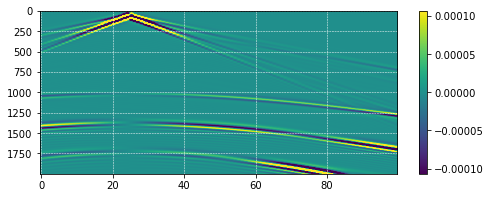

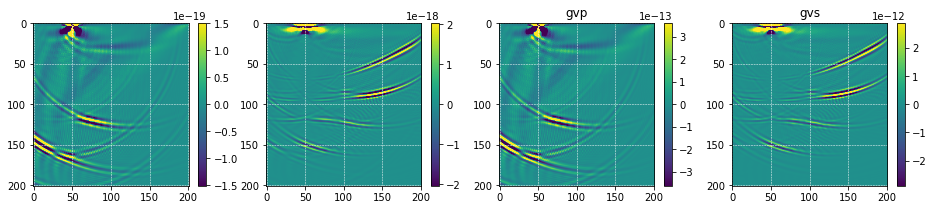

In [59]:
plt.figure(figsize=(8,3))
imshow(read_su('results/dadj_Shot0001.su'),perc=98)

corr=read('results/correlate_gradient',n=(3*nx,nz))
glda=corr[:,  nx:2*nx]
gmu =corr[:,2*nx:]

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(glda,perc=98)
plt.subplot(1,4,2); imshow(gmu ,perc=98)
plt.subplot(1,4,3); imshow(gvp(glda),title='gvp',perc=98)
plt.subplot(1,4,4); imshow(gvs(glda,gmu),title='gvs',perc=98)

#### GradientTest on gvp

In [60]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       px" >> setup
#!echo "PARAMETER   'vp:1500:2000'" >> setup
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup

!rm -r results
!../../exe/gradienttest_DAS_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06   14.1008997       14.1008968      0.286102295     -0.373936713      -1.30700350     F
 1st cond   9.99999975E-05   14.1008759       14.1008968     -0.209808350     -0.373936713       1.78227758     T
 1st cond   1.00000005E-03   14.1005669       14.1008968     -0.329971284     -0.373936713       1.13324022     T
 1st cond   9.99999978E-03   14.0974197       14.1008968     -0.347709656     -0.373936713       1.07542801     T
 1st cond  0.100000001       14.0668201       14.1008968     -0.340766907     -0.373936713       1.09733868     T
 1st cond   1.00000000       13.7839956       14.1008968     -0.316901207     -0.373936713       1.17997885     T


In [61]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       px" >> setup
#!echo "PARAMETER   'vp:1500:2000'" >> setup
!echo "ALPHAS '-1e-5 -1e-4 -1e-3 -1e-2 -1e-1 -1' " >> setup

!rm -r results
!../../exe/gradienttest_DAS_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond  -9.99999975E-06   14.1008997       14.1008968     -0.286102295     -0.373936713       1.30700350     F
 1st cond  -9.99999975E-05   14.1009293       14.1008968     -0.324249268     -0.373936713       1.15323842     F
 1st cond  -1.00000005E-03   14.1012230       14.1008968     -0.326156586     -0.373936713       1.14649439     F
 1st cond  -9.99999978E-03   14.1041832       14.1008968     -0.328636169     -0.373936713       1.13784409     F
 1st cond -0.100000001       14.1345415       14.1008968     -0.336446762     -0.373936713       1.11142910     F
 1st cond  -1.00000000       14.4599266       14.1008968     -0.359029770     -0.373936713       1.04152012     F


#### GradientTest on gvs

In [62]:
!cp setup_default setup
!echo 'FILE_MODEL   init' >> setup
!echo "SCOMP        pz" >> setup
!echo "RCOMP        px" >> setup
!echo "PARAMETER   'vs:578:1039'" >> setup
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup

!rm -r results
!../../exe/gradienttest_DAS_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06   7.59075975       7.59076834     -0.858306885      -1.17314148       1.36680889     T
 1st cond   9.99999975E-05   7.59065485       7.59076834      -1.13487244      -1.17314148       1.03372097     T
 1st cond   1.00000005E-03   7.58963013       7.59076834      -1.13821030      -1.17314148       1.03068960     T
 1st cond   9.99999978E-03   7.57951736       7.59076834      -1.12509727      -1.17314148       1.04270232     T
 1st cond  0.100000001       7.48143435       7.59076834      -1.09333992      -1.17314148       1.07298875     T
 1st cond   1.00000000       6.81052732       7.59076834     -0.780241013      -1.17314148       1.50356293     T


In [63]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       px" >> setup
!echo "PARAMETER   'vs:578:1039'" >> setup
!echo "ALPHAS '-1e-5 -1e-4 -1e-3 -1e-2 -1e-1 -1' " >> setup

!rm -r results
!../../exe/gradienttest_DAS_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond  -9.99999975E-06   7.59078550       7.59076834      -1.71661377      -1.17314148      0.683404446     F
 1st cond  -9.99999975E-05   7.59088373       7.59076834      -1.15394592      -1.17314148       1.01663470     F
 1st cond  -1.00000005E-03   7.59189653       7.59076834      -1.12819672      -1.17314148       1.03983772     F
 1st cond  -9.99999978E-03   7.60206890       7.59076834      -1.13005638      -1.17314148       1.03812647     F
 1st cond -0.100000001       7.70693731       7.59076834      -1.16168976      -1.17314148       1.00985777     F
 1st cond  -1.00000000       9.05457687       7.59076834      -1.46380854      -1.17314148      0.801430941     F


### pz-ex

#### Obs & Syn data

In [64]:
!cp setup_default setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       ex" >> setup
!echo "DIR_OUT     results_obs" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 642672 Nov 20 16:35 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: 65073d2
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 17:06:10
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_obs
 Output directory:results_obs/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/dx

In [65]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       ex" >> setup
!echo "DIR_OUT     results_syn" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 642672 Nov 20 16:35 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: 65073d2
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 17:06:13
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : results_syn
 Output directory:results_syn/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.606 *Vmax/dx

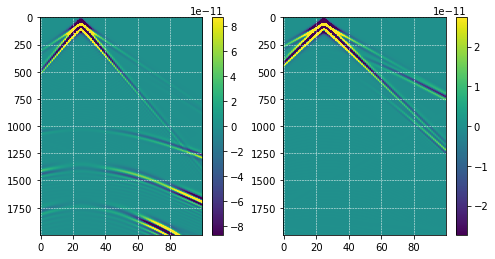

In [66]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); imshow(read_su('results_obs/Ru_Shot0001.su'),perc=98)
plt.subplot(1,2,2); imshow(read_su('results_syn/Ru_Shot0001.su'),perc=98)

#### Gradient

In [67]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       ex" >> setup
!echo "ALPHAS      1 " >> setup
run(app='../../exe/gradienttest_DAS_FDSG_O4_velocities-density')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           4
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/04_GradientTest
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 919552 Nov 20 16:50 ../../exe/gradienttest_DAS_FDSG_O4_velocities-density
 Git Commit: 320b080
 Git Branch: DAS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 11/20/2023
System time: 17:06:16
System timezone: +03:00
                        
       WELCOME TO SeisJIMU FWI       
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT is NOT found, take default: ./results/
 Output directory:./results/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax

 it----         500
 fld_a minmax values:  -2.16049340E-18   2.31918365E-18
 fld_u minmax values:  -2.44740210E-03   2.71616108E-03
 Elapsed time to load boundary               1.74403191E-02
 Elapsed time to update strains             0.500762701    
 Elapsed time to rm source strains           3.67164612E-03
 Elapsed time to update momenta             0.655362606    
 Elapsed time to rm source momenta           1.23236179E-02
 Elapsed time ----------------------------
 Elapsed time to add adjsource strains       1.26426220E-02
 Elapsed time to update adj strains         0.574398279    
 Elapsed time to add adjsource momenta       1.05075836E-02
 Elapsed time to update adj momenta         0.624041557    
 Elapsed time to extract&write fields        0.00000000    
 Elapsed time to correlate                   2.31308937E-02
 Viewing the snapshots (if written) with SU ximage/xmovie:
 ximage < snap_rfield%*  n1=249 perc=99
 xmovie < snap_rfield%*  n1=249 n2=249 clip=?e-?? loop=2 title=%g


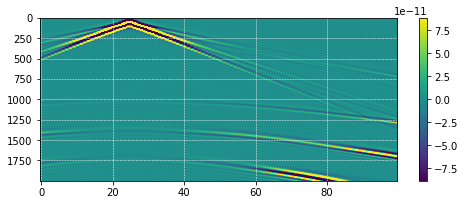

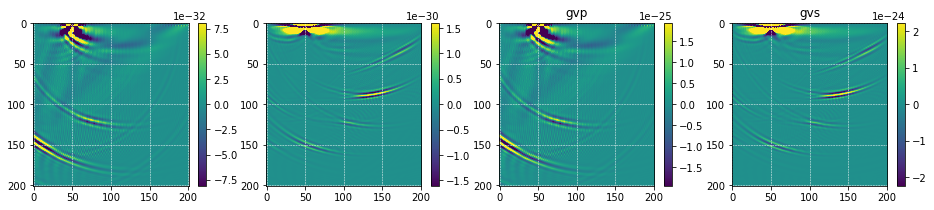

In [68]:
plt.figure(figsize=(8,3))
imshow(read_su('results/dadj_Shot0001.su'),perc=98)

corr=read('results/correlate_gradient',n=(3*nx,nz))
glda=corr[:,  nx:2*nx]
gmu =corr[:,2*nx:]

plt.figure(figsize=(16,3))
plt.subplot(1,4,1); imshow(glda,perc=98)
plt.subplot(1,4,2); imshow(gmu ,perc=98)
plt.subplot(1,4,3); imshow(gvp(glda),title='gvp',perc=98)
plt.subplot(1,4,4); imshow(gvs(glda,gmu),title='gvs',perc=98)

#### GradientTest on gvp

In [69]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       ex" >> setup
#!echo "PARAMETER   'vp:1500:2000'" >> setup
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup

!rm -r results
!../../exe/gradienttest_DAS_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06   49.5180664       49.5180893      -2.28881836     -0.315986812      0.138056740     T
 1st cond   9.99999975E-05   49.5180206       49.5180893     -0.686645508     -0.315986812      0.460189164     T
 1st cond   1.00000005E-03   49.5177078       49.5180893     -0.381469697     -0.315986812      0.828340530     T
 1st cond   9.99999978E-03   49.5154037       49.5180893     -0.268554688     -0.315986812       1.17662001     T
 1st cond  0.100000001       49.4911232       49.5180893     -0.269660950     -0.315986812       1.17179298     T
 1st cond   1.00000000       49.2843628       49.5180893     -0.233726501     -0.315986812       1.35195112     T


In [70]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       ex" >> setup
#!echo "PARAMETER   'vp:1500:2000'" >> setup
!echo "ALPHAS '-1e-5 -1e-4 -1e-3 -1e-2 -1e-1 -1' " >> setup

!rm -r results
!../../exe/gradienttest_DAS_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond  -9.99999975E-06   49.5180664       49.5180893       2.28881836     -0.315986812     -0.138056740     T
 1st cond  -9.99999975E-05   49.5180740       49.5180893      0.152587891     -0.315986812      -2.07085109     T
 1st cond  -1.00000005E-03   49.5183029       49.5180893     -0.213623032     -0.315986812       1.47917950     F
 1st cond  -9.99999978E-03   49.5206985       49.5180893     -0.260925293     -0.315986812       1.21102405     F
 1st cond -0.100000001       49.5445137       49.5180893     -0.264244080     -0.315986812       1.19581413     F
 1st cond  -1.00000000       49.8110275       49.5180893     -0.292938232     -0.315986812       1.07868063     F


#### GradientTest on gvs

In [71]:
!cp setup_default setup
!echo 'FILE_MODEL   init' >> setup
!echo "SCOMP        pz" >> setup
!echo "RCOMP        ex" >> setup
!echo "PARAMETER   'vs:578:1039'" >> setup
!echo "ALPHAS '1e-5 1e-4 1e-3 1e-2 1e-1 1' " >> setup

!rm -r results
!../../exe/gradienttest_DAS_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond   9.99999975E-06   21.4925232       21.4925613      -3.81469727      -1.40377986      0.367992461     T
 1st cond   9.99999975E-05   21.4924183       21.4925613      -1.43051147      -1.40377986      0.981313229     T
 1st cond   1.00000005E-03   21.4911499       21.4925613      -1.41143787      -1.40377986      0.994574308     T
 1st cond   9.99999978E-03   21.4787674       21.4925613      -1.37939453      -1.40377986       1.01767826     T
 1st cond  0.100000001       21.3576794       21.4925613      -1.34881973      -1.40377986       1.04074681     T
 1st cond   1.00000000       20.4677486       21.4925613      -1.02481270      -1.40377986       1.36979163     T


In [72]:
!cp setup_default setup
!echo 'FILE_MODEL  init' >> setup
!echo "SCOMP       pz" >> setup
!echo "RCOMP       ex" >> setup
!echo "PARAMETER   'vs:578:1039'" >> setup
!echo "ALPHAS '-1e-5 -1e-4 -1e-3 -1e-2 -1e-1 -1' " >> setup

!rm -r results
!../../exe/gradienttest_DAS_FDSG_O4_velocities-density  setup > out

!echo '            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond'
!grep '1st cond' out

            alpha    pert%f    curr%f    (pert%f-curr%f)/alpha    curr%g_dot_d    if_1st_cond
 1st cond  -9.99999975E-06   21.4925728       21.4925613      -1.14440918      -1.40377986       1.22664154     F
 1st cond  -9.99999975E-05   21.4926853       21.4925613      -1.23977661      -1.40377986       1.13228452     F
 1st cond  -1.00000005E-03   21.4939613       21.4925613      -1.39999378      -1.40377986       1.00270438     F
 1st cond  -9.99999978E-03   21.5065536       21.4925613      -1.39923096      -1.40377986       1.00325096     F
 1st cond -0.100000001       21.6350727       21.4925613      -1.42511368      -1.40377986      0.985030115     F
 1st cond  -1.00000000       23.2375336       21.4925613      -1.74497223      -1.40377986      0.804471195     F
